In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

##Load in data

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Data Science Capstone/all_feature_data_avg.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
##Find 5 meteorological variables most correlated with yield.

features=['tmmx', 'rmax', 'vs', 'sph', 'srad', 'vpd', 'rmin' , 'pr', 'tmmn', 'th']
all_correlations=df[['yield']+features].corr()
yield_correlations=all_correlations.loc['yield', features]

yield_corr_sorted=yield_correlations.reindex(yield_correlations.abs().sort_values(ascending=False).head(5).index)

print(yield_corr_sorted)

th     -0.139559
rmin    0.048481
rmax   -0.041743
srad    0.036095
tmmx   -0.018928
Name: yield, dtype: float64


th (Wind direction at 10 m)

rmin (Minimum Near-Surface Relative Humidity)

rmax (Maximum Near-Surface Relative Humidity)

srad (Surface Downwelling Solar Radiation)

tmmx (Maximum Near-Surface Air Temperature)

In [4]:
##Fit linear regression model with interaction terms among the 5 most yield-correlated weather variables

highest_5_corr_features=yield_correlations.reindex(yield_correlations.abs().sort_values(ascending=False).index).head(5).index.tolist()

import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

X=df[highest_5_corr_features]
y=df['yield']

poly=PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly=poly.fit_transform(X)

feature_names=poly.get_feature_names_out(highest_5_corr_features)

X_sm=sm.add_constant(X_poly)
model=sm.OLS(y, X_sm).fit()

In [ ]:
##Identify the top 3 interaction terms that improve yield prediction

lin_reg_results=pd.DataFrame({'Feature': ['Intercept']+list(feature_names), 'Coefficient': model.params.values, "p Value": model.pvalues.values})
lin_reg_results_interactions=lin_reg_results[lin_reg_results['Feature'].str.contains(' ')]
print(lin_reg_results_interactions.sort_values('p Value').head(3))

      Feature  Coefficient        p Value
7     th rmax    -0.114105  1.335308e-205
6     th rmin     0.080851  5.753362e-190
15  srad tmmx    -0.058041  7.447934e-101


th (Wind direction at 10 m) & rmax (Maximum Near-Surface Relative Humidity)

th (Wind direction at 10 m) & rmin (Minimum Near-Surface Relative Humidity)

srad (Surface Downwelling Solar Radiation) & tmmx (Maximum Near-Surface Air Temperature)

In [5]:
##Determine years with stress events (high temperature >90th + low precipitation <10th)

def determine_stress_events(regions):
  tmmx_90=regions['tmmx'].quantile(0.9)
  pr_10=regions['pr'].quantile(0.1)
  regions['stress_event']=(regions['tmmx']>tmmx_90) & (regions['pr']<pr_10)
  return regions

df_stress_events=df.groupby('id2').apply(determine_stress_events).reset_index(drop=True)

# Re-calculate county_stress_freq here
county_stress_freq = df_stress_events.groupby("id2").size().reset_index(name="stress_count")

stress_event_years=df_stress_events[df_stress_events['stress_event']].groupby('year').size()
print(stress_event_years)

year
1980    358
1982      6
1983      5
1986      3
1987    253
1988    385
1989     13
1990      1
1991     58
1994      1
1998     47
1999     27
2000     19
2001     12
2005     33
2006      5
2007    170
2010     46
2011     75
2012    470
2016      9
dtype: int64


/tmp/ipython-input-3835975668.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_stress_events=df.groupby('id2').apply(determine_stress_events).reset_index(drop=True)


In [6]:
# Count the number of stress events per county
stress_events_per_county = df_stress_events.groupby('id2')['stress_event'].sum().reset_index(name='stress_event_count')

# Display the result
print("Number of stress events per county:")
display(stress_events_per_county)

Number of stress events per county:


,id2,stress_event_count
0,111,0
1,112,1
2,113,1
3,119,2
4,120,1
...,...,...
1361,3121,2
1362,3122,1
1363,3123,1
1364,3124,1


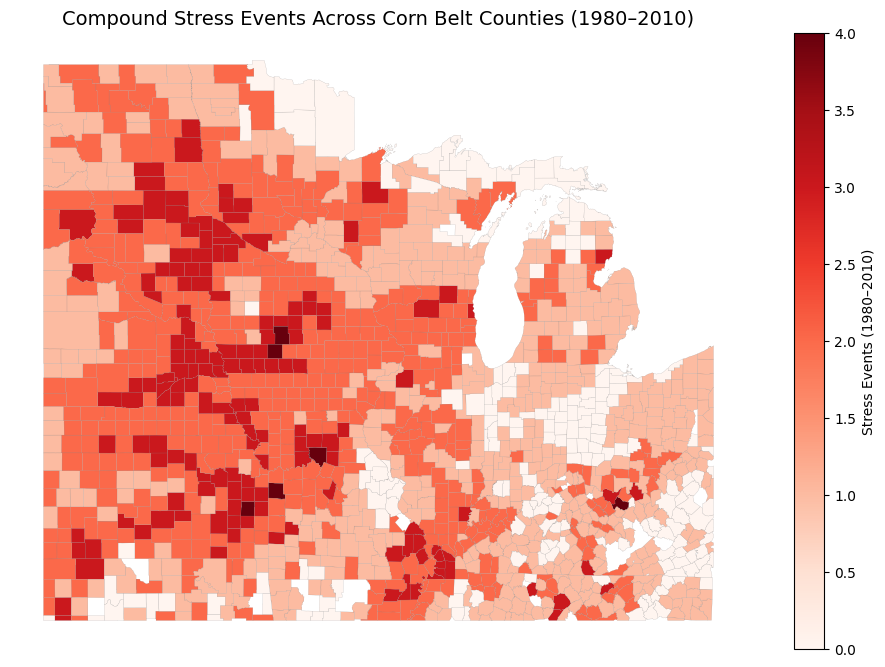

In [7]:
##Map the frequency of compound stress events across counties

import geopandas as gpd
import matplotlib.pyplot as plt

#Load county shapefile
counties = gpd.read_file("/content/drive/MyDrive/Data Science Capstone/CornBeltShapefiles/CornBeltCounty.shp")

#Merge stress data
geo_df = counties.merge(stress_events_per_county, left_on="ID_2", right_on="id2", how="left")

fig, ax = plt.subplots(figsize=(12, 8))

# Counties shaded by stress_event_count
geo_df.plot(
    column="stress_event_count",
    cmap="Reds",
    linewidth=0.1,
    ax=ax,
    edgecolor="grey",
    legend=True,
    legend_kwds={"label": "Stress Events (1980–2010)"})

ax.set_title("Compound Stress Events Across Corn Belt Counties (1980–2010)", fontsize=14)
ax.axis("off")

plt.show()

Correlation between stress_count and yield: 0.20899742493099055


/tmp/ipython-input-604401205.py:64: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


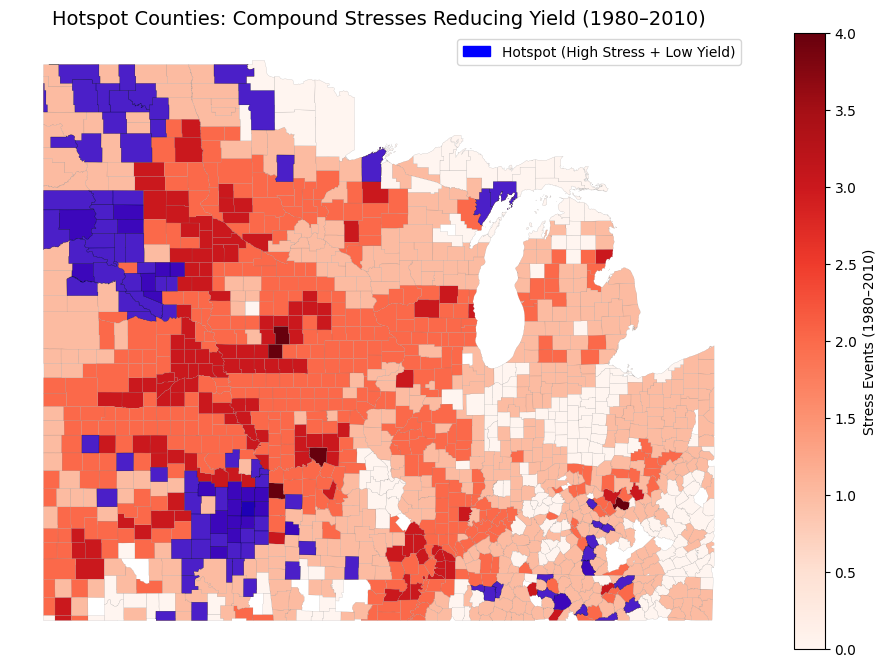

In [11]:
##Highlight hotspot regions where compound stresses reduce yields

import matplotlib.patches as mpatches

#Aggregate yield data by county
yield_by_county=df.groupby("id2")["yield"].mean().reset_index()

#Merge with stress data
stress_yield=stress_events_per_county.merge(yield_by_county, left_on="id2", right_on="id2")

#Correlation
corr = stress_yield[["stress_event_count", "yield"]].corr().iloc[0,1]
print("Correlation between stress_count and yield:", corr)

stress_yield_clean=stress_yield.dropna(subset=["stress_event_count", "yield"]).copy()

#If stress_count has NaN after merge, replace with 0
stress_yield_clean["stress_event_count"] = stress_yield_clean["stress_event_count"].fillna(0)


#Quantile thresholds
stress_thresh=stress_yield["stress_event_count"].quantile(0.75)
yield_thresh=stress_yield["yield"].quantile(0.25)

#Flag hotspots
stress_yield["hotspot"]=(
    (stress_yield["stress_event_count"] >= stress_thresh) &
    (stress_yield["yield"] <= yield_thresh))

#Fill NaN values in 'hotspot' column with False
stress_yield['hotspot'] = stress_yield['hotspot'].fillna(False)

#Merge hotspot info with counties
geo_df = counties.merge(stress_yield, left_on="ID_2", right_on="id2", how="left")

#Drop rows with NaN in 'stress_count' before plotting
geo_df_cleaned = geo_df.dropna(subset=['stress_event_count'])

fig, ax = plt.subplots(figsize=(12, 8))

#stress count as base layer
geo_df_cleaned.plot(
    column="stress_event_count",
    cmap="Reds",
    linewidth=0.1,
    ax=ax,
    edgecolor="grey",
    legend=True,
    legend_kwds={"label": "Stress Events (1980–2010)"})

#Overlay hotspots
geo_df_cleaned[geo_df_cleaned["hotspot"]].plot(
    ax=ax,
    color="blue",
    edgecolor="black",
    linewidth=0.2,
    alpha=0.7,
    label="Hotspot (High Stress + Low Yield)")

ax.set_title("Hotspot Counties: Compound Stresses Reducing Yield (1980–2010)", fontsize=14)
ax.axis("off")

#legend for the hotspot layer
hotspot_patch = mpatches.Patch(color='blue', label='Hotspot (High Stress + Low Yield)')
#Add both legends
handles, labels = ax.get_legend_handles_labels()
handles.append(hotspot_patch)
ax.legend(handles=handles)


plt.show()